## CREATING QA BOT WITH PYTHON

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

Using TensorFlow backend.


### Load Data

In [12]:
#Loading training data
with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)

In [13]:
#Loading test data
with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [4]:
len(train_data), len(test_data)

(10000, 1000)

In [5]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

#### Train data contains 10, 000 tuples. Each tuple holds a list comprehension of the story, question, and  a "yes"/"no" answer.

In [6]:
# Story
" ".join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [7]:
# Question
" ".join(train_data[0][1])

'Is Sandra in the hallway ?'

In [8]:
# Answer
train_data[0][2]

'no'

### Data Preparation

In [14]:
all_data = train_data + test_data # Combine train data and test data

In [15]:
def vocab_creator(data):
    '''
    Creating vocabulary of words present in dataset
    '''
    vocab = set()
    for story, question, answer in data:
        vocab = vocab.union(set(story))
        vocab = vocab.union(set(question))
    vocab.add('yes')
    vocab.add('no')
    
    tokenizer = Tokenizer(filters = [])
    tokenizer.fit_on_texts(vocab)
    
    max_story_len = max([len(datum[0]) for datum in data]) #maximum story length
    max_question_len = max([len(datum[1]) for datum in data]) #maximum question length
    
    return tokenizer, max_story_len, max_question_len, vocab

In [16]:
tokenizer, max_story_len, max_question_len, vocab = vocab_creator(all_data) 
vocab_size = len(vocab) + 1 #size of our vocabulary
input_sequence = Input((max_story_len,)) #placeholder for shape = (max_story_len, batch_size)
question = Input((max_question_len,))

In [17]:
def vectorize_stories(data, word_index = tokenizer.word_index, 
                      max_story_len = max_story_len, 
                      max_question_len = max_question_len):
    '''
    Vectorizes story, question, and answer with padded sequences
    X = Stories
    X_Q = Questions
    Y  = Answers
    '''
    X  = []
    X_Q = []
    Y = []
    
    for stories ,questions, answers in data:
        '''
        For each story
        [23,14,43,...]
        '''
        x = [word_index[word.lower()] for word in stories]
        x_q = [word_index[word.lower()] for word in questions]
        
        y = np.zeros(len(word_index) + 1)
        
        y[word_index[answers]] = 1
        
        X.append(x)
        X_Q.append(x_q)
        Y.append(y)
    return (pad_sequences(X, maxlen = max_story_len), pad_sequences(X_Q, maxlen = max_question_len), np.array(Y))

In [18]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [19]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

### DATA MODELING

In [21]:
def model(vocab_size = vocab_size, max_question_len = max_question_len, input_sequence = input_sequence, question = question):
    '''
    Input Encoder M
    Gets embedded to a seq of vecotrs
    '''
    input_encoder_m = Sequential()
    input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim = 64))
    input_encoder_m.add(Dropout(0.3))

    '''
    Input Encoder C
    Gets embedded to a seq of vecotrs
    '''
    input_encoder_c = Sequential()
    input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim = max_question_len))
    input_encoder_c.add(Dropout(.3))
    
    '''
    Question Encoder
    '''
    question_encoder = Sequential()
    question_encoder.add(Embedding(input_dim=vocab_size, output_dim = 64, input_length = max_question_len))
    question_encoder.add(Dropout(.3))
    
    '''
    ENCODED RESULT <-- ENCODER(INPUT)
    '''
    input_encoded_m = input_encoder_m(input_sequence)
    input_encoded_c = input_encoder_c(input_sequence)
    question_encoded =  question_encoder(question)

    '''
    Use dot product to compute the match between the first input vector
    seq and the query
    '''
    match = dot([input_encoded_m, question_encoded], axes =(2,2))
    match = Activation('softmax')(match)
    
    '''
    Add above match matrix to second input vector seq
    '''
    response = add([match, input_encoded_c])
    response = Permute((2,1))(response) # convert it to have a output of samples dim by query_max_len by story_max_len
    
    '''
    Now we can concat the match matrix with the question vector seq
    '''
    answer = concatenate([response, question_encoded])
    answer = LSTM(32)(answer)
    answer = Dropout(0.5)(answer)
    answer = Dense(vocab_size)(answer) # (sample, vocab_size)
    answer = Activation('softmax')(answer)
    model = Model([input_sequence, question], answer)
    model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
### Run model
model = model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_4[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

### TRAINING

In [23]:
### Training data
history = model.fit([inputs_train, queries_train], answers_train, batch_size = 32, epochs = 40, validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/40
10000/10000 [==============================] - 5s 463us/step - loss: 0.8859 - acc: 0.4965 - val_loss: 0.6946 - val_acc: 0.4970
Epoch 2/40
10000/10000 [==============================] - 3s 340us/step - loss: 0.7048 - acc: 0.5038 - val_loss: 0.6997 - val_acc: 0.5030
Epoch 3/40
10000/10000 [==============================] - 3s 345us/step - loss: 0.6965 - acc: 0.5024 - val_loss: 0.6935 - val_acc: 0.4970
Epoch 4/40
10000/10000 [==============================] - 4s 354us/step - loss: 0.6948 - acc: 0.5076 - val_loss: 0.6933 - val_acc: 0.4970
Epoch 5/40
10000/10000 [==============================] - 4s 392us/step - loss: 0.6939 - acc: 0.5131 - val_loss: 0.6937 - val_acc: 0.4970
Epoch 6/40
10000/10000 [==============================] - 5s 464us/step - loss: 0.6951 - acc: 0.4950 - val_loss: 0.6935 - val_acc: 0.4970
Epoch 7/40
10000/10000 [==============================] - 4s 432us/step - loss: 0.6941 - acc: 0.5005 - val_loss: 0.6927 - v

### Evaluating Model
#### Plotting Training History

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


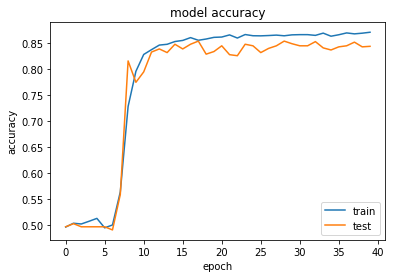

In [24]:
print(history.history.keys())

#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

In [ ]:
model.save('qachatbot.h5')

### Prediction

I will create my own story and question to test the model on. Keep in mind that our model was trained on the words in the "vocab" *only*, so in creating our own story, we will have to stick to words in the vocabulary.

Also, keep a space between punctuations so as to recreate the input we trained on

In [25]:
_, _ , _, vocab = vocab_creator(train_data + test_data)

In [26]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [33]:
my_story = "Mary dropped the milk in the kitchen . Mary went to the office . "
my_question = "Is Mary in the office ?"

In [34]:
mydata = [(my_story.split(), my_question.split(), 'yes')]
mydata

[(['Mary',
   'dropped',
   'the',
   'milk',
   'in',
   'the',
   'kitchen',
   '.',
   'Mary',
   'went',
   'to',
   'the',
   'office',
   '.'],
  ['Is', 'Mary', 'in', 'the', 'office', '?'],
  'yes')]

In [35]:
my_story, my_question, my_answer = vectorize_stories(mydata)

In [36]:
predict_result = model.predict(([my_story, my_question]))

In [37]:
val_max = np.argmax(predict_result[0])
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key
print(k)

yes


In [38]:
predict_result[0][val_max] #Probability of prediction

0.9023414